

---


# **Introctuction**


---



## ***Survey***

### Where do we see crystal structures in real life?

- Ice, diamond, metals

### The crystal structure of which substance is shown in the [video](https://youtu.be/3W1QA26RZtU)?

Ice, red spheres are oxygen and white are hydrogen (H2O, well-known formula)

### What are differences between water molecule and ice?

order, symmetry, atomic sequence, shape, repeatability

### What is crystal structure?

Ordered arrangement of atoms forming symmetric patterns



---


# **Preparation**


---



This notebook: https://github.com/MMDLab/MLMD_in_20min/blob/main/MLMD_20mins.ipynb

---



Libraries installation and import

In [1]:
# install pymatgen
! pip install pymatgen

# import table processor
import pandas as pd
import json

# load raw dataset
! wget 'https://github.com/MMDLab/MLMD_in_20min/blob/main/db.json'
with open('db.json', 'r') as f:
  data = json.load(f)
data = pd.DataFrame(eval(data['payload']['blob']['rawLines'][0]))
data = data.reset_index(drop=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.7/807.7 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 24.2 MB/s eta 0:00:00
--2024-03-05 12:28:52--  https://github.com/MMDLab/MLMD_in_20min/blob/main/db.json
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25275 (25K) [text/plain]
Saving to: ‘db.json’

db.json             100%[=============



---


# **Dataset exploration**


---



See the dataset

In [20]:
data.sample(5)

,pretty_formula,elements,unit_cell_formula,elasticity.K_VRH,nsites,spacegroup.symbol,bulk_modulus,atomic_concentrations
80,GeP,"[Ge, P]","{'Ge': 1.0, 'P': 1.0}",65.0,2,F-43m,65.0,"{'Ge': 0.5, 'P': 0.5}"
82,MgS,"[Mg, S]","{'Mg': 1.0, 'S': 1.0}",55.0,2,F-43m,55.0,"{'Mg': 0.5, 'S': 0.5}"
79,CuS,"[Cu, S]","{'Cu': 1.0, 'S': 1.0}",77.0,2,F-43m,77.0,"{'Cu': 0.5, 'S': 0.5}"
11,GaSb,"[Ga, Sb]","{'Ga': 1.0, 'Sb': 1.0}",45.0,2,F-43m,45.0,"{'Ga': 0.5, 'Sb': 0.5}"
15,MoC,"[Mo, C]","{'Mo': 1.0, 'C': 1.0}",246.0,2,F-43m,246.0,"{'Mo': 0.5, 'C': 0.5}"


In [3]:
# library to work with arrays
import numpy as np

# unique elements in the dataset
np.unique(np.concatenate(data['elements'].values))

array(['Ag', 'Al', 'As', 'Au', 'B', 'Be', 'Bi', 'Br', 'C', 'Ca', 'Cd',
       'Cl', 'Co', 'Cr', 'Cu', 'Dy', 'Er', 'Fe', 'Ga', 'Gd', 'Ge', 'Hf',
       'Hg', 'Ho', 'I', 'In', 'Ir', 'Mg', 'Mn', 'Mo', 'N', 'Nb', 'Ni',
       'O', 'Os', 'P', 'Pd', 'Pr', 'Pt', 'Rb', 'Re', 'Rh', 'Ru', 'S',
       'Sb', 'Sc', 'Se', 'Si', 'Sn', 'Ta', 'Tc', 'Te', 'Ti', 'Tl', 'Tm',
       'U', 'V', 'W', 'Y', 'Zn', 'Zr'], dtype='<U2')

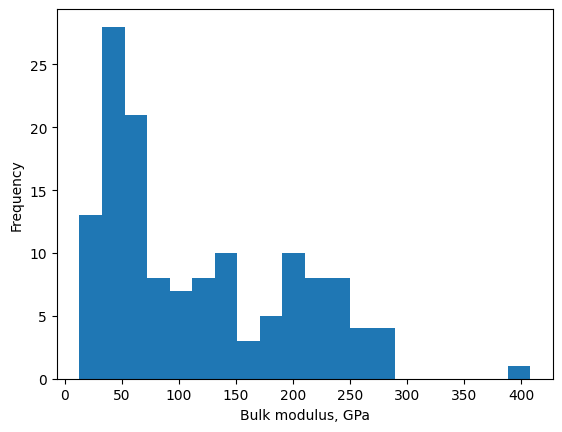

In [5]:
# import plotter
import matplotlib.pyplot as plt

# bulk modulus distribitution
data.bulk_modulus.plot(kind='hist', bins=20)
plt.xlabel('Bulk modulus, GPa') ; plt.show()

## ***Survey***

### What do all the materials considered have in common?

Symmetry, number of chemical elements, elements' concentrations

### How do you think: What is bulk modulus?

Measure of the resistance of a substance to bulk compression

### How do you think: What is "feature" in machine learning?

 An individual measurable property or characteristic of a phenomenon.

### **What is the most simple way to digitize (featurize) information on any material?*

To use concentration weighted periodic properties of atoms in the composition



---


# **Goal**


---



Build a machine learning model to predict bulk modulus.



---


# **Feature engineering**


---



In [6]:
# import tables of individual properties of elements
from pymatgen.core import periodic_table

# define a function to extract information from tables
def get_elem_props(elem: str = None):
    elem_props = {}
    elem_props['Z'] = periodic_table.Element(elem).Z  # charge number = atomic number
    elem_props['row'] = periodic_table.Element(elem).row # row in periodic table
    elem_props['group'] = periodic_table.Element(elem).group # group in periodic table
    elem_props['atomic_mass'] = periodic_table.Element(elem).atomic_mass # atomic mass
    elem_props['atomic_radius'] = periodic_table.Element(elem).atomic_radius # atomic radius
    return elem_props # return a dictionary of properties

# See example
get_elem_props('Ti')

{'Z': 22, 'row': 4, 'group': 4, 'atomic_mass': 47.867, 'atomic_radius': 1.4}

In [8]:
# see the unit cell formula = chemical formula
data.loc[0, ['pretty_formula', 'unit_cell_formula']]

pretty_formula                         AlAs
unit_cell_formula    {'Al': 1.0, 'As': 1.0}
Name: 0, dtype: object

In [9]:
# collect names of all atomic properties in the dictionary
my_list = []
for e in data.loc[0,'unit_cell_formula']:
  my_list.append(get_elem_props(elem = e))
  print(e, ':', get_elem_props(elem = e))

# see examlpe of features to calculate
my_dict = {}
for p in get_elem_props('Ti').keys():
  tmp = []
  for i in my_list:
    tmp.append(i[p])
  my_dict[p] = np.array(tmp).mean()
print('Mean :', my_dict)

Al : {'Z': 13, 'row': 3, 'group': 13, 'atomic_mass': 26.9815386, 'atomic_radius': 1.25}
As : {'Z': 33, 'row': 4, 'group': 15, 'atomic_mass': 74.9216, 'atomic_radius': 1.15}
Mean : {'Z': 23.0, 'row': 3.5, 'group': 14.0, 'atomic_mass': 50.9515693, 'atomic_radius': 1.2}


In [10]:
# define a function to calculate concantaration weighted properties for a single composition
def get_avg_prop(concentrations: dict=None, prop: str=None):
    ''' concentrations = dict obj '''
    avg_prop = 0
    try:
        for symbol, concentraion in concentrations.items():
            avg_prop += get_elem_props(symbol)[prop]*concentraion
        return avg_prop
    except Exception as e:
        print(f'while {symbol} is processed {e} is occured. NaN value will be returned!')
        return np.nan

# Apply function to entire dataset
data_for_ml = pd.DataFrame()
data_for_ml['formula'] = data['pretty_formula']
for p in get_elem_props('Ti').keys():
  data_for_ml[f'mean_{p}'] = data['atomic_concentrations'].apply(lambda x: get_avg_prop(x,p))
data_for_ml['bulk_modulus'] = data['bulk_modulus']

# See the results
data_for_ml

,formula,mean_Z,mean_row,mean_group,mean_atomic_mass,mean_atomic_radius,bulk_modulus
0,AlAs,23.000000,3.500000,14.000000,50.951569,1.200000,70.0
1,OsN,41.500000,4.000000,11.500000,102.118350,0.975000,271.0
2,AgBr,41.000000,4.500000,14.000000,93.886100,1.375000,28.0
3,Be5Au,16.500000,2.666667,3.500000,40.337913,1.100000,138.0
4,InAs,41.000000,4.500000,14.000000,94.869800,1.350000,49.0
...,...,...,...,...,...,...,...
133,CrN,15.500000,3.000000,10.500000,33.001400,1.025000,205.0
134,DyCu5,35.166667,4.333333,9.666667,80.038333,1.416667,107.0
135,BeSe,19.000000,3.000000,9.000000,43.986091,1.100000,49.0
136,CdC,27.000000,3.500000,13.000000,62.210850,1.125000,81.0


### What column is unnecessary? Why?

formula, it couldn't be used as a regression variable



---


# **Features cross-correlations**


---



<Axes: >

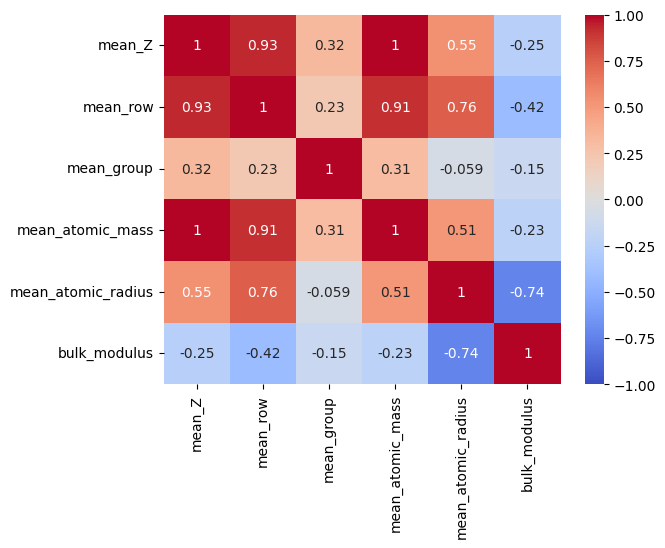

In [12]:
# import another plotter
import seaborn as sns

# plot heatmap reflecting cross-correlation coefficients
# those coeffs are Pearson correlation coefficients
# these are coefficients [ a ] of pair linear regressions [ y = ax + b ]
# Max val = 1, Min val = -1 for direct and inverse dependence
sns.heatmap(data_for_ml.corr(numeric_only=True), cmap='coolwarm', vmin=-1, vmax=1, annot=True)

### See the correlations between the `mean_row` and `mean_Z` features.
- Do we need to include both of them?

### Explanation

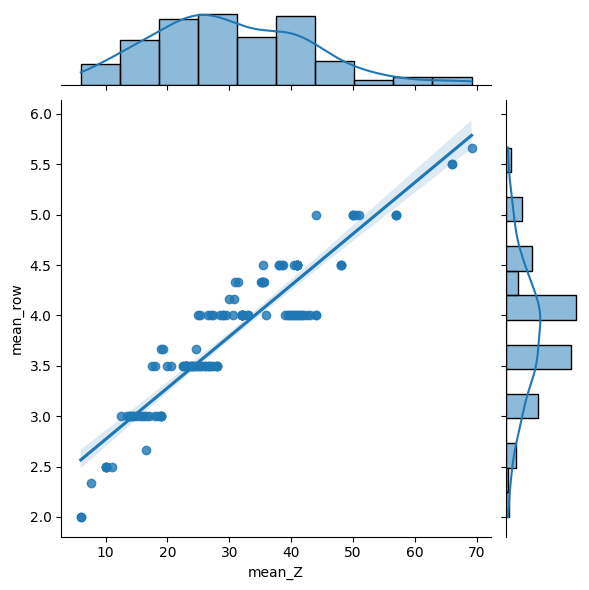

In [13]:
sns.jointplot(data=data_for_ml, x='mean_Z', y='mean_row', kind='reg')

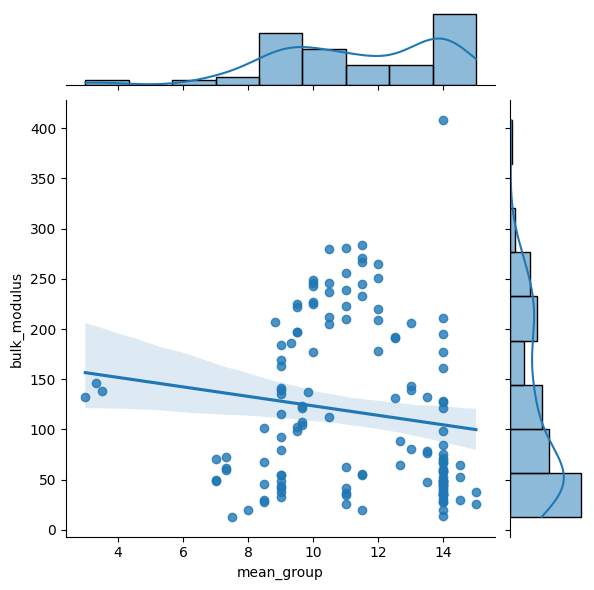

In [14]:
sns.jointplot(data=data_for_ml, x='mean_group', y='bulk_modulus', kind='reg')

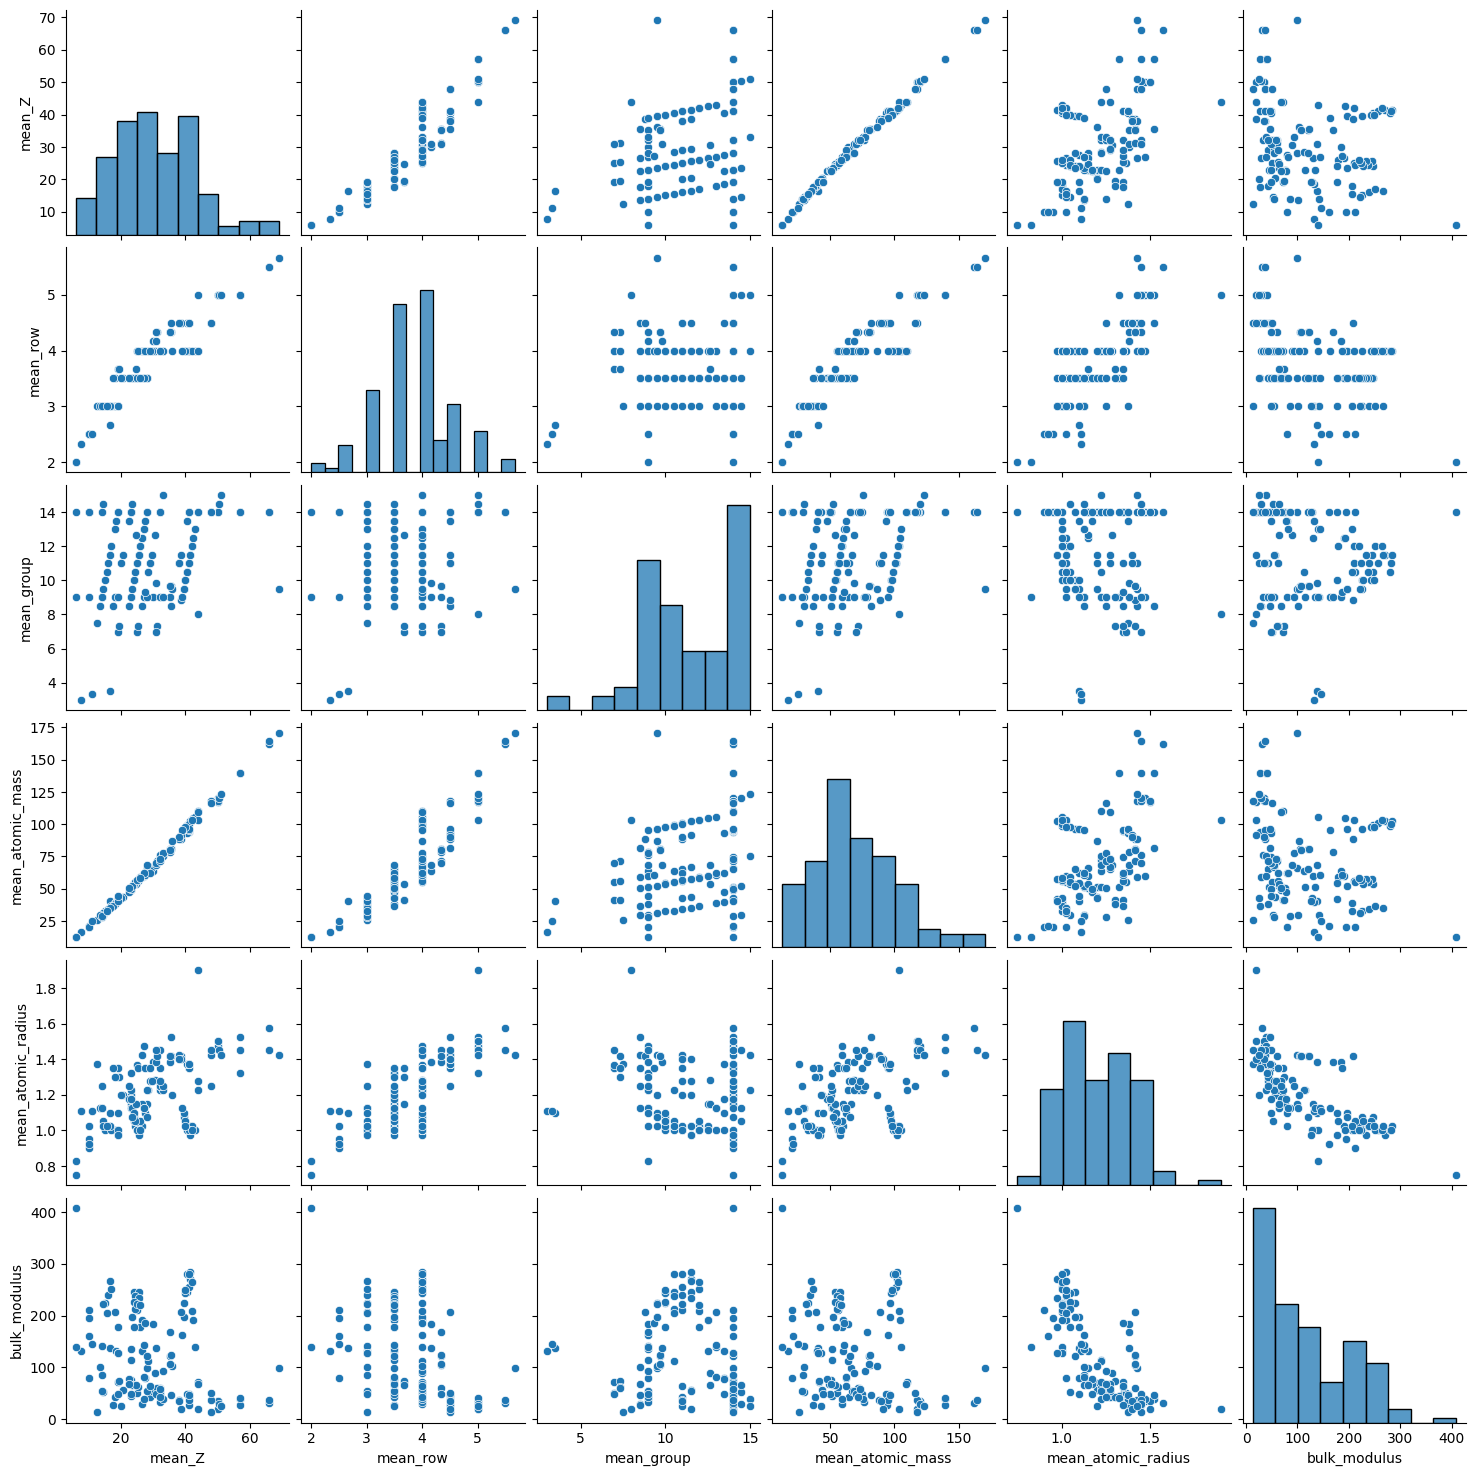

In [15]:
sns.pairplot(data_for_ml)

### What is the purpose of featurization of a chemical composition?

Numerically characterize chemical compositions so that the model can accurately distinguish them as diverse as possible

## Correlations of features and target values

<Axes: >

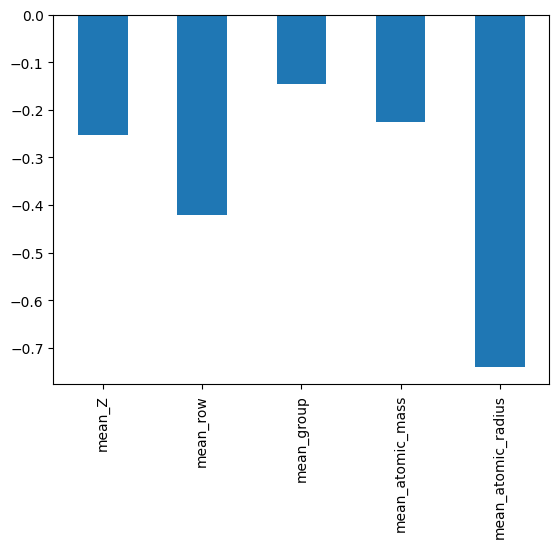

In [16]:
data_for_ml.corr(numeric_only=True)['bulk_modulus'].drop('bulk_modulus', axis='rows').plot(kind='bar')

### Is it possible to solve a regression equation if there are no strong correlations between the variables and the target?

Yes, since multiple characteristics provide more information than individual one



---


# **Training and test sets preparation**


---



In [19]:
# Define a variables of regression equations
X = data_for_ml.copy()

# Drop unused columns
X = X.drop(['formula', 'bulk_modulus'], axis='columns')

# See the result (3 random rows)
X.sample(3)

,mean_Z,mean_row,mean_group,mean_atomic_mass,mean_atomic_radius
93,44.000000,4.0,14.000000,109.195000,1.275000
63,30.666667,4.0,12.666667,68.684000,1.283333
22,23.000000,3.5,14.000000,50.348381,1.150000


In [21]:
# Define targets for each composition
y = data_for_ml['bulk_modulus']
y.sample(3)

77     210.0
31      71.0
110    169.0
Name: bulk_modulus, dtype: float64

In [22]:
# import instrument for train and test subsets splitting
from sklearn.model_selection import train_test_split

# splitting on train & test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=16)

# See the sizes of prepared subsets
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# See the 3 random samples of feature vectors
X_train.sample(3)

(124, 5) (124,) (14, 5) (14,)


,mean_Z,mean_row,mean_group,mean_atomic_mass,mean_atomic_radius
14,41.0,4.0,11.0,101.120350,1.000
83,28.5,4.0,10.5,63.456881,1.225
11,41.0,4.5,14.0,95.741500,1.375


*Target equasion will be:*

$$a_1 x_1 + a_2 x_2 + a_3 x_3 + a_4 x_4 + a_5 x_5 = y_{bulk}$$

More info provided at the [link](https://en.wikipedia.org/wiki/Ordinary_least_squares)

In [23]:
# import an instrument to bulid a multilinear regression model
from sklearn.linear_model import LinearRegression

# define a model type from source library (class object)
model = LinearRegression()

# Fit the model
# That means that we are to solve the system of 137 equasions
# by the Ordinary least squares method
model.fit(X_train, y_train)

LinearRegression()

In [35]:
# collect pretty representation of obtained regression equasion
pp = ''
for coef, feat in zip(model.coef_, X.columns):
  pp += f'{round(coef)}*{feat}'
pp += ' = bulk_modulus'

# print result
print('-'*79)
print('Fitted regression equasion:')
print('-'*79)
print(pp)

-------------------------------------------------------------------------------
Fitted regression equasion:
-------------------------------------------------------------------------------
29*mean_Z-11*mean_row-13*mean_group-10*mean_atomic_mass-499*mean_atomic_radius = bulk_modulus




---


# **Test the model on hold-out set**


---



### Validation metrics

---

Dispersion characteristic of the differences between the true and predicted values - `determination coefficient`:

1. $R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat y_i)^2}{\sum_{i=1}^n (y_i - \bar y_i)^2}$

where:
- $\hat y$ - predicted value
- $y_i$ - true value
- $\bar y = \frac{1}{n} \sum_{i=1}^n y_i$

---

Total `Mean Absolute Error`:

2. $ MAE = \frac{1}{n_{samples}} \sum_{i=0}^{n-1} | y_i - \hat y_i | $

where:
- $i=0$ - starting index of predicted target and values in corresponding arrays
- $y_i$ - true value
- $\hat y$ - predicted value

---

See complite guidline on ML-models estimation via the [link](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error)

R2 = 0.903
MAE = 19.89


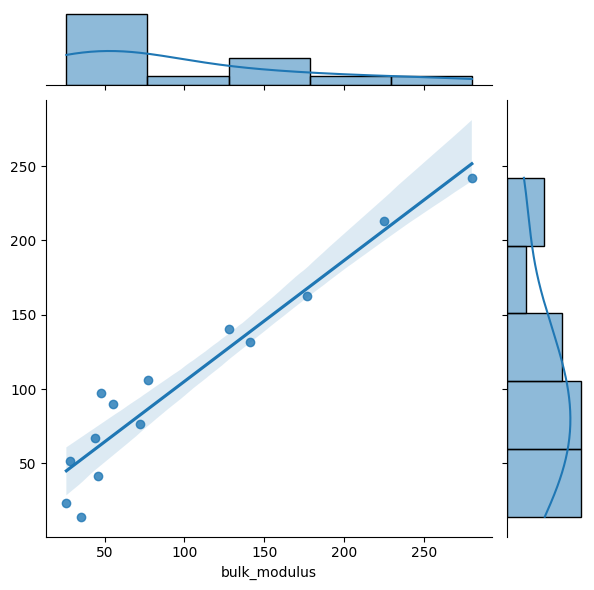

In [38]:
# import ready-to-use functions for mentioned metrics caluculating
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Plot regression graphs
sns.jointplot(x=y_test, y=model.predict(X_test), kind='reg')

# print selected metrics
print('R2 =', round(r2_score(y_test, model.predict(X_test)), 3))
print('MAE =', round(mean_absolute_error(y_test, model.predict(X_test)), 3))

## ***Survey***

### What are the main elements of a machine learning model for predicting bulk modulus based on information about chemical composition of materials?

Features, training and test set, regression (classification) core

### How to characterize the performance of a machine learning model?

- Using a set of versatile validation metrics
- **to use different validation techiques* ([K-Fold CV](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold))



---


# **Task (Controlled Practice)**


---



1. Find in **Training and test sets preparation** section very important part where *ratio of the training and test* datasets is defined.

2. By changing the ratios of the training and test datasets, characterize the resulting model.

3. Discuss the generalized characterization of obtained model.

**Note:** Each participant chooses his own ratio



---


# **Task (Production)**


---



Using the obtained model and information from the periodic table, try to come up with a new material that will have the highest elasticity compared to those already used.

---

***`Tip: `***
Note, that all used compoisitions are binaries!

---

![img](https://upload.wikimedia.org/wikipedia/commons/8/89/Colour_18-col_PT_with_labels.png)

### See the uneque elements presented in the compositions of the entire dataset

In [39]:
np.unique(np.concatenate(data['elements'].values))

array(['Ag', 'Al', 'As', 'Au', 'B', 'Be', 'Bi', 'Br', 'C', 'Ca', 'Cd',
       'Cl', 'Co', 'Cr', 'Cu', 'Dy', 'Er', 'Fe', 'Ga', 'Gd', 'Ge', 'Hf',
       'Hg', 'Ho', 'I', 'In', 'Ir', 'Mg', 'Mn', 'Mo', 'N', 'Nb', 'Ni',
       'O', 'Os', 'P', 'Pd', 'Pr', 'Pt', 'Rb', 'Re', 'Rh', 'Ru', 'S',
       'Sb', 'Sc', 'Se', 'Si', 'Sn', 'Ta', 'Tc', 'Te', 'Ti', 'Tl', 'Tm',
       'U', 'V', 'W', 'Y', 'Zn', 'Zr'], dtype='<U2')

### See how different elements are affect to the corresponding bulk moduli

<Axes: >

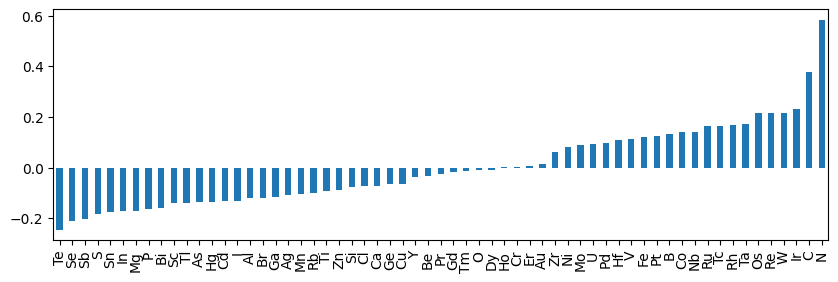

In [40]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df_corr = pd.DataFrame(mlb.fit_transform(data['elements']))
df_corr.columns = mlb.classes_
df_corr['bulk_modulus'] = data['bulk_modulus']
df_corr = df_corr.corr()
df_corr = df_corr.loc['bulk_modulus']
df_corr = df_corr.drop(['bulk_modulus'])
df_corr = df_corr.sort_values()
df_corr.plot(kind='bar', figsize=(10,3))

## Utils (to skip)

In [63]:
# import instrument for formula parsing
from pymatgen.core import Composition

# define a function to get a dictionary object of elements' concentraions
def get_atomic_concentrations(formula: dict=None):
    n = sum(list(formula.values()))
    concs = formula.copy()
    for key in formula.keys():
        concs[key] = concs[key] / n
    return concs

# define a function to featurize formula as mentioned above
def featurize_formula(f=None):
  f2c = lambda x: Composition(x).as_dict()
  df = pd.DataFrame()
  df['formula'] = [f]
  df['formula'] = df['formula'].apply(f2c)
  df['formula'] = df['formula'].apply(get_atomic_concentrations)
  for p in get_elem_props('Ti').keys():
    df[f'mean_{p}'] = df['formula'].apply(lambda x: get_avg_prop(x,p))
  df = df.drop(['formula'], axis='columns')
  return df

# Train the model on the entire dataset
model.fit(X,y)

LinearRegression()

## Try here

In [85]:
# input suggested fromula here
formula = 'H2O'

# See the highest value
best = data.sort_values(by=['bulk_modulus'], ascending=False).head(1)
print('-'*79)
print(f'Best is: [ {best["pretty_formula"].values[0]} ] Bulk modulus = {best["bulk_modulus"].values[0]} GPa')
print('-'*79)

# See predicted Bulk modulus
prediction = model.predict(featurize_formula(formula))
print(f'\nPredicted bulk moduli of [ {Composition(formula)} ] composition:',
        round(prediction[0]), 'GPa')

-------------------------------------------------------------------------------
Best is: [ BN ] Bulk modulus = 408.0 GPa
-------------------------------------------------------------------------------

Predicted bulk moduli of [ H2 O1 ] composition: 494 GPa


---

Final quiz (external link will be provided).

---